In [43]:
import numpy as np
import cupy as cp
import dxchange
import matplotlib.pyplot as plt
import h5py
from holotomo.holo import G, GT
from holotomo.magnification import M, MT
from holotomo.shift import S, ST, registration_shift
from holotomo.chunking import gpu_batch
from holotomo.proc import remove_outliers
from holotomo.recon_methods import CTFPurePhase, multiPaganin
import holotomo.chunking as chunking


%matplotlib inline

cp.cuda.Device(0).use()
chunking.global_chunk = 1

# Init data sizes and parametes of the PXM of ID16A

In [44]:
n = 2048
ndist = 4
ntheta = 1

# ID16a setup
ndist = 4

detector_pixelsize = 3e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length

focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:ndist]-sx0
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size

norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = z1[0]  # positions of the probe for reconstruction
z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = (z1p+z2p)/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/magnifications2[0]/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2

# allow padding if there are shifts of the probe
pad = n//16
# sample size after demagnification
ne = int(np.ceil((n+2*pad)/norm_magnifications[-1]/8))*8  # make multiple of 8

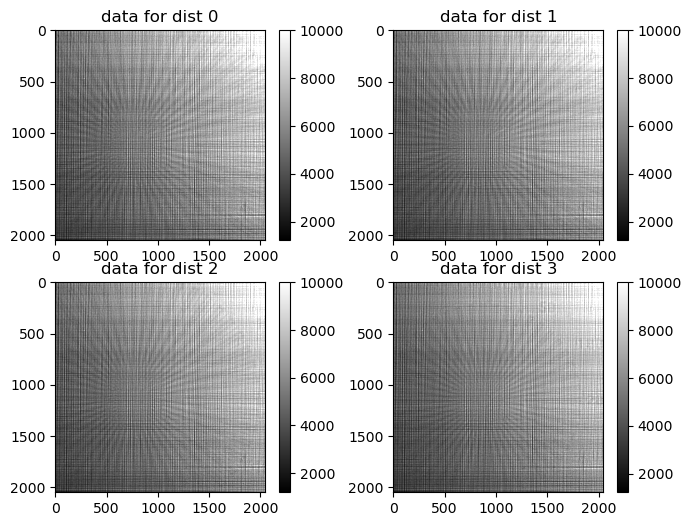

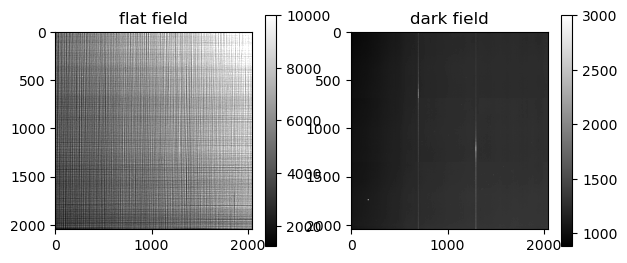

In [45]:

nref = 20
ndark = 20
data00 = np.zeros([ntheta,ndist,n,n],dtype='float32')
ref00 = np.zeros([nref,ndist,n,n],dtype='float32')
dark00 = np.zeros([ndark,ndist,n,n],dtype='float32')
for k in range(ndist):
    with h5py.File(f'/data/viktor/SiemensLH_33keV_010nm_holoNfpScan_0{k+1}/SiemensLH_33keV_010nm_holoNfpScan_0{k+1}0000.h5','r') as fid:
        data00[:,k] = fid['/entry_0000/measurement/data'][:1,1024-n//2:1024+n//2,1024-n//2:1024+n//2][:]
    with h5py.File(f'/data/viktor/SiemensLH_33keV_010nm_holoNfpScan_0{k+1}/ref_0000.h5','r') as fid:
        ref00[:,k]=fid['/entry_0000/measurement/data'][:nref,1024-n//2:1024+n//2,1024-n//2:1024+n//2][:]
    with h5py.File(f'/data/viktor/SiemensLH_33keV_010nm_holoNfpScan_0{k+1}/dark_0000.h5','r') as fid:
        dark00[:,k]=fid['/entry_0000/measurement/data'][:ndark,1024-n//2:1024+n//2,1024-n//2:1024+n//2][:]

# remove outliers
for k in range(ndist):
    radius = 7
    threshold = 20000
    data00[:,k] = remove_outliers(data00[:,k], radius, threshold)
    ref00[:,k] = remove_outliers(ref00[:,k], radius, threshold)        

fig, axs = plt.subplots(2, 2, figsize=(8,6))
im=axs[0,0].imshow(data00[0,0],cmap='gray',vmax=10000)
axs[0,0].set_title(f'data for dist {0}')
fig.colorbar(im)
im=axs[0,1].imshow(data00[0,1],cmap='gray',vmax=10000)
axs[0,1].set_title(f'data for dist {1}')
fig.colorbar(im)
im=axs[1,0].imshow(data00[0,2],cmap='gray',vmax=10000)
axs[1,0].set_title(f'data for dist {2}')
fig.colorbar(im)
im=axs[1,1].imshow(data00[0,3],cmap='gray',vmax=10000)
axs[1,1].set_title(f'data for dist {3}')
fig.colorbar(im)

fig, axs = plt.subplots(1, 2, figsize=(7, 3))
im=axs[0].imshow(ref00[0,0],cmap='gray',vmax=10000)
fig.colorbar(im)
axs[0].set_title(f'flat field')
im=axs[1].imshow(dark00[0,0],cmap='gray',vmax=3000)
fig.colorbar(im)
axs[1].set_title(f'dark field')  
plt.show()

## Take mean for flat and dark

In [46]:
ref00 = np.mean(ref00,axis=0)[np.newaxis]
dark00 = np.mean(dark00,axis=0)[np.newaxis]

### Normalize everything wrt to the mean of the reference image

In [47]:
mean_value = np.mean(ref00)
dark00 = dark00.astype('float32')/mean_value
ref00 = ref00.astype('float32')/mean_value
data00 = data00.astype('float32')/mean_value


data00 = data00-np.mean(dark00,axis=0)
ref00 = ref00-np.mean(dark00,axis=0)

data00[data00<0] = 0
ref00[ref00<0] = 0

# Find shifts of reference images

In [48]:
shifts_ref0 = np.zeros([1, ndist, 2], dtype='float32')
for k in range(ndist):
    shifts_ref0[:, k] = registration_shift(ref00[:, k], ref00[:, 0], upsample_factor=1000)
print(f'Found shifts: \n{shifts_ref0=}')

shifts_ref = np.zeros([ntheta, ndist, 2], dtype='float32')
for k in range(ndist):
    im = np.tile(ref00[0, 0], [ntheta, 1, 1])
    shifts_ref[:, k] = registration_shift(data00[:, k], im, upsample_factor=1000)  
print(f'Found shifts: \n{shifts_ref=}')


Found shifts: 
shifts_ref0=array([[[ 0.   ,  0.   ],
        [ 0.003,  0.018],
        [-0.003,  0.076],
        [ 0.149,  0.197]]], dtype=float32)
Found shifts: 
shifts_ref=array([[[ 0.003, -0.023],
        [ 0.007, -0.006],
        [-0.003,  0.05 ],
        [ 0.154,  0.166]]], dtype=float32)


### Assuming the shifts are calculated, shifts refs back

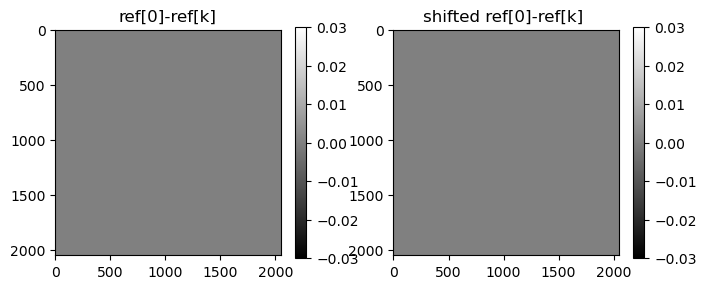

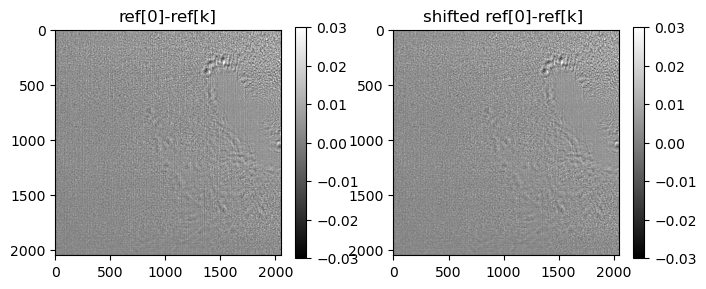

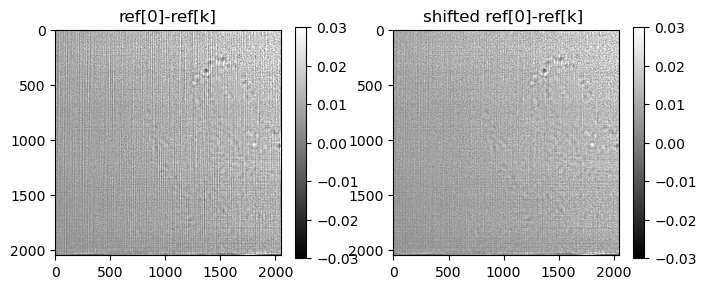

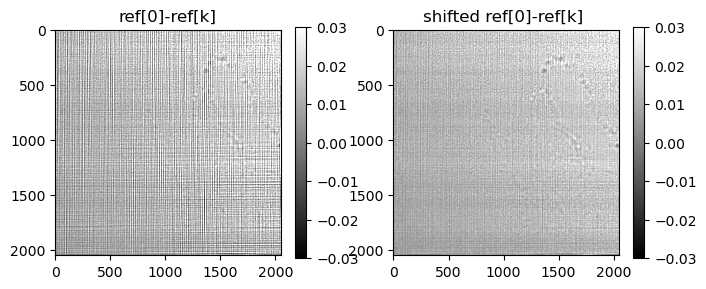

In [49]:
data0 = data00.copy()
ref0 = ref00.copy()
# shifted refs for correction
for k in range(ndist):
    # shift refs back
    ref0[:, k] = ST(ref0[:, k].astype('complex64'), shifts_ref0[:, k]).real

ref0c = np.tile(np.array(ref0), (ntheta, 1, 1, 1))
for k in range(ndist):
    # shift refs the position where they were when collecting data
    ref0c[:, k] = S(ref0c[:, k].astype('complex64'), shifts_ref[:, k]).real

for k in range(4):
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    im = axs[0].imshow(ref00[0, 0]-ref00[0, k], cmap='gray',vmax=.03,vmin=-.03)
    axs[0].set_title('ref[0]-ref[k]')
    fig.colorbar(im)
    # ,vmin=-500,vmax=500)
    im = axs[1].imshow(ref0[0, 0]-ref0[0, k], cmap='gray',vmax=.03,vmin=-.03)
    axs[1].set_title('shifted ref[0]-ref[k] ')
    fig.colorbar(im)

### divide data by the reference image

In [50]:
rdata = data0/(ref0+1e-9)

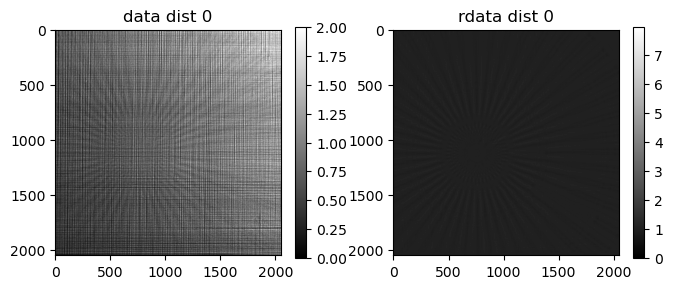

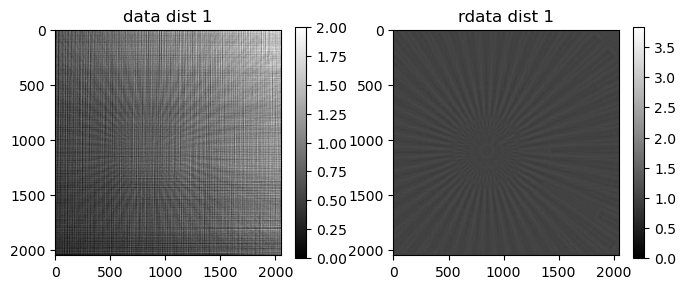

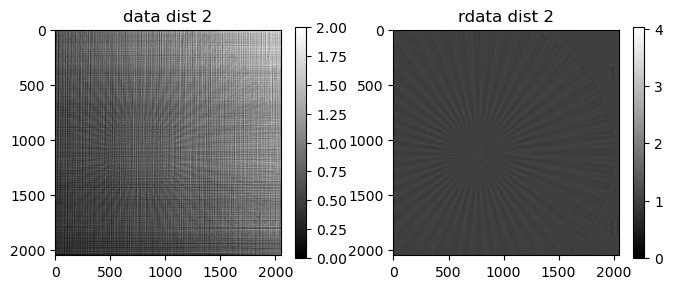

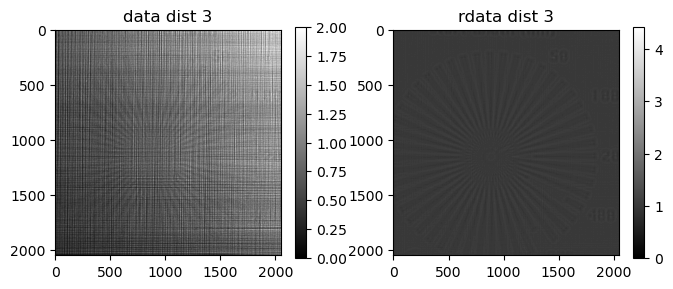

In [51]:
for k in range(ndist):
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    im=axs[0].imshow(data0[0,k],cmap='gray',vmax=2)
    axs[0].set_title(f'data dist {k}')
    fig.colorbar(im)
    im=axs[1].imshow(rdata[0,k],cmap='gray')#,vmax=1.1,vmin=0.9)
    axs[1].set_title(f'rdata dist {k}')
    fig.colorbar(im)

### Scale images

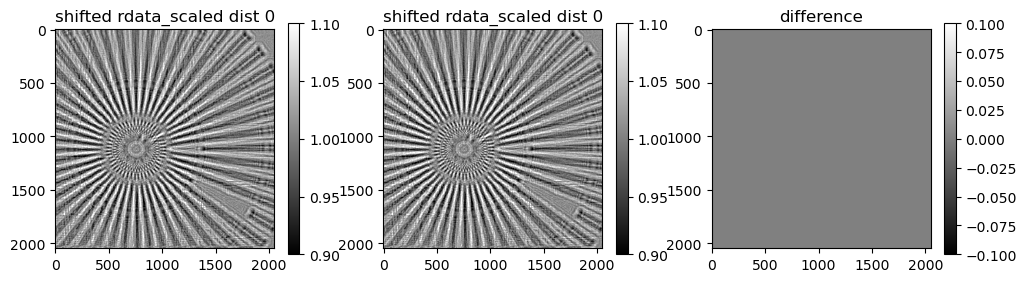

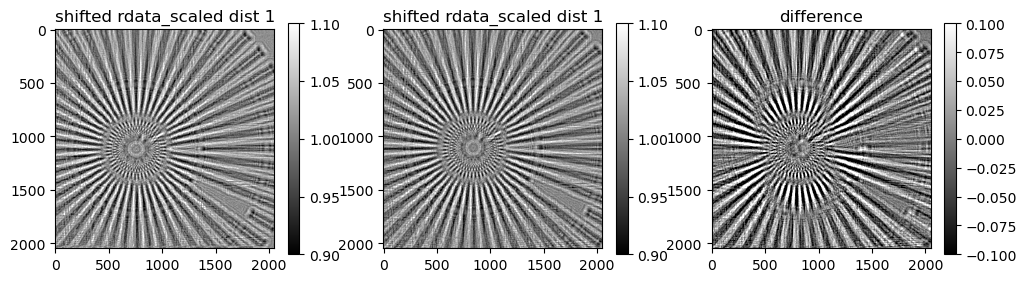

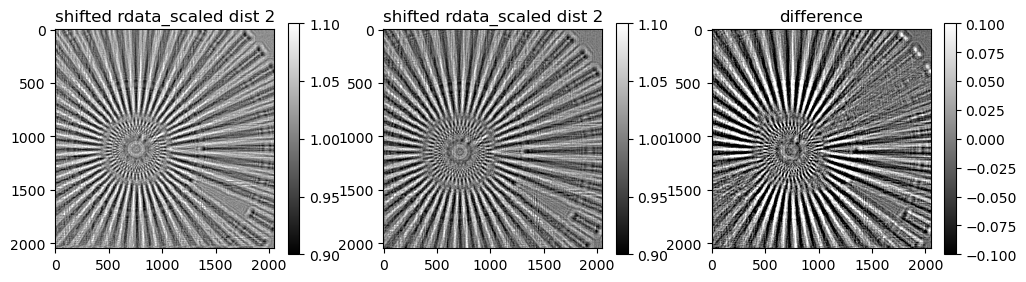

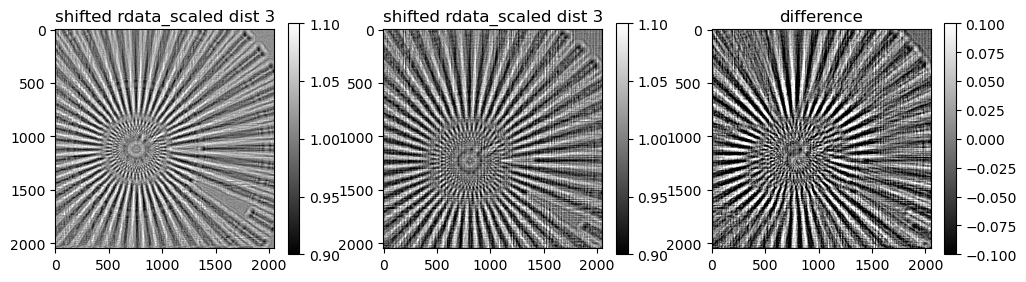

In [52]:
rdata_scaled = rdata.copy()

for k in range(ndist):
    rdata_scaled[:, k] = M(rdata_scaled[:, k], 1/norm_magnifications[k], n).real

for k in range(ndist):
    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    im = axs[0].imshow(rdata_scaled[0, 0], cmap='gray', vmin=0.9, vmax=1.1)
    axs[0].set_title(f'shifted rdata_scaled dist {k}')
    fig.colorbar(im)
    im = axs[1].imshow(rdata_scaled[0, k], cmap='gray', vmin=0.9, vmax=1.1)
    axs[1].set_title(f'shifted rdata_scaled dist {k}')
    fig.colorbar(im)
    im = axs[2].imshow(rdata_scaled[0, k]-rdata_scaled[0, 0], cmap='gray', vmin=-0.1, vmax=0.1)
    axs[2].set_title(f'difference')
    fig.colorbar(im)

### Align images between different planes


#### Approach 1. Align data

In [53]:
# shifts_drift = np.zeros([ntheta,ndist,2],dtype='float32')

# for k in range(1,ndist):
#     shifts_drift[:,k] = registration_shift(rdata_scaled[:,k],rdata_scaled[:,0],upsample_factor=1000)

# # note shifts_drift should be after magnification.
# shifts_drift*=norm_magnifications[np.newaxis,:,np.newaxis]

# shifts_drift_median = shifts_drift.copy()
# shifts_drift_median[:] = np.median(shifts_drift,axis=0)

# print(shifts_drift_median[0],shifts_drift_init[0])
# for k in range(ndist):
#     fig, axs = plt.subplots(1, 2, figsize=(10, 3))
#     im=axs[0].plot(shifts_drift[:,k,0],'.')
#     im=axs[0].plot(shifts_drift_median[:,k,0],'.')
#     im=axs[0].plot(shifts_drift_init[:,k,0],'r.')
#     axs[0].set_title(f'distance {k}, shifts y')
#     im=axs[1].plot(shifts_drift[:,k,1],'.')
#     im=axs[1].plot(shifts_drift_median[:,k,1],'.')
#     im=axs[1].plot(shifts_drift_init[:,k,1],'r.')
#     axs[1].set_title(f'distance {k}, shifts x')
#     # plt.show()

#### Approach 2. Align CTF reconstructions from 1 distance

In [54]:
recCTF_1dist = np.zeros([ntheta, ndist, n, n], dtype='float32')
distances_ctf = (distances/norm_magnifications**2)[:ndist]

for k in range(ndist):
    recCTF_1dist[:, k] = CTFPurePhase(
        rdata_scaled[:, k:k+1], distances_ctf[k:k+1], wavelength, voxelsize, 1e-2)

plt.figure(figsize=(4, 4))
plt.title(f'CTF reconstruction for distance {ndist-1}')
plt.imshow(recCTF_1dist[0, -1], cmap='gray')
plt.show()

shifts_drift = np.zeros([ntheta, ndist, 2], dtype='float32')

for k in range(1, ndist):
    shifts_drift[:, k] = registration_shift(
        recCTF_1dist[:, k], recCTF_1dist[:, 0], upsample_factor=1000)

# note shifts_drift should be after magnification.
shifts_drift *= norm_magnifications[np.newaxis, :, np.newaxis]

    
print(f'Found shifts: \n{shifts_drift=}')


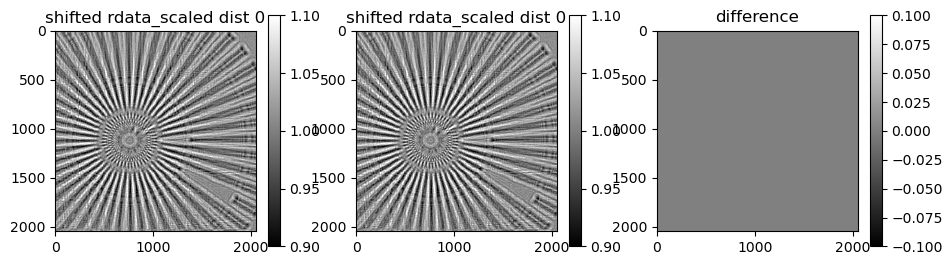

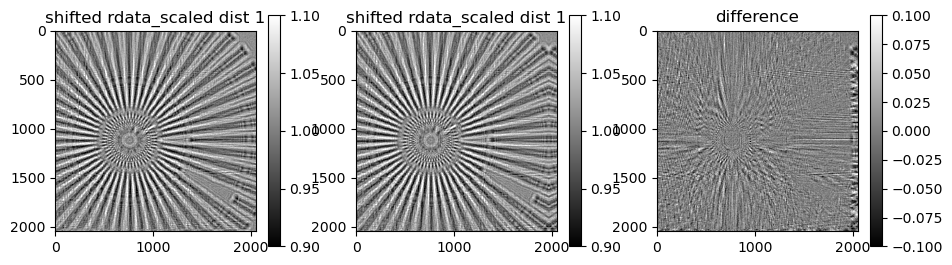

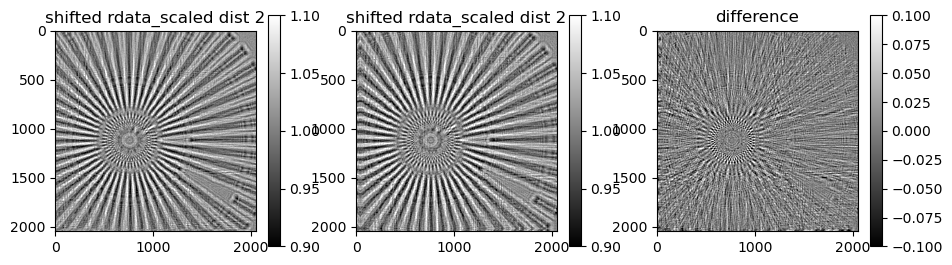

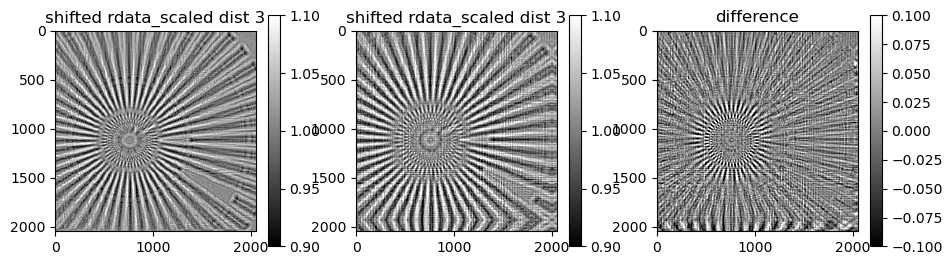

In [ ]:
rdata_scaled_aligned = rdata_scaled.copy()
for k in range(ndist):
    rdata_scaled_aligned[:, k] = ST(rdata_scaled[:, k], shifts_drift[:, k]/norm_magnifications[k]).real
    
for k in range(ndist):
    fig, axs = plt.subplots(1, 3, figsize=(11, 3))
    im = axs[0].imshow(rdata_scaled_aligned[0, 0], cmap='gray', vmin=.9, vmax=1.1)
    axs[0].set_title(f'shifted rdata_scaled dist {k}')
    fig.colorbar(im)
    im = axs[1].imshow(rdata_scaled_aligned[0, k], cmap='gray', vmin=.9, vmax=1.1)
    axs[1].set_title(f'shifted rdata_scaled dist {k}')
    fig.colorbar(im)
    im = axs[2].imshow(rdata_scaled_aligned[0, k] - rdata_scaled_aligned[0, 0], cmap='gray', vmin=-0.1, vmax=.1)
    axs[2].set_title(f'difference')
    fig.colorbar(im)

#### Reconstruction by the MultiPaganin method

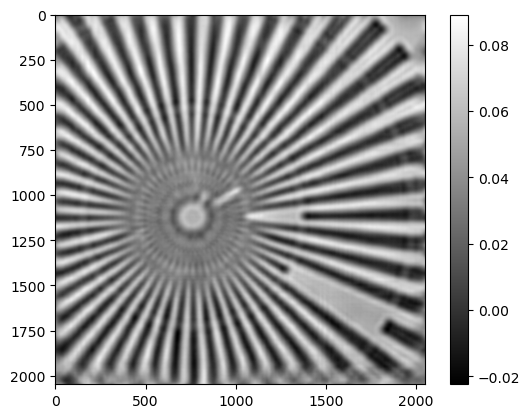

In [ ]:
# distances should not be normalized
distances_pag = (distances/norm_magnifications**2)[:ndist]
recMultiPaganin = multiPaganin(rdata_scaled_aligned, distances_pag, wavelength, voxelsize, 10, 1e-12)
plt.imshow(recMultiPaganin[0],cmap='gray')
plt.colorbar()

#### Reconstruction by the CTF pure phase method

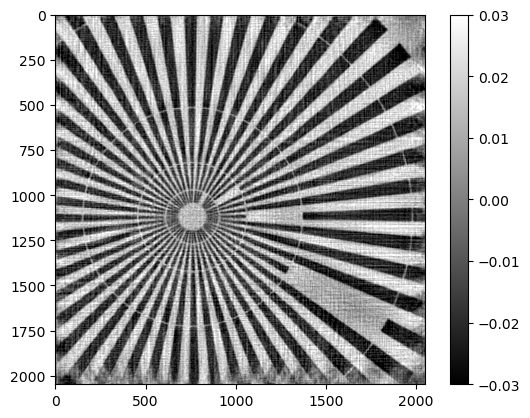

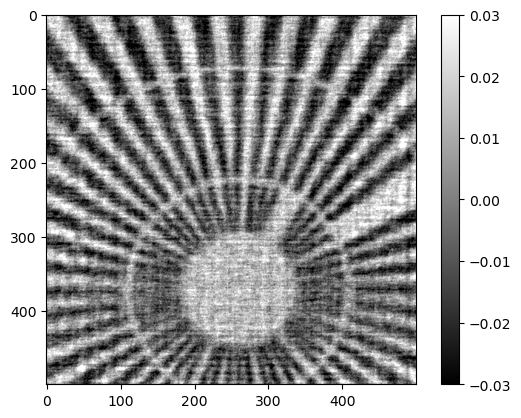

In [ ]:
distances_ctf = (distances/norm_magnifications**2)[:ndist]

recCTF = CTFPurePhase(rdata_scaled_aligned, distances_ctf, wavelength, voxelsize, 1e-2)
plt.imshow(recCTF[0],cmap='gray',vmax=0.03,vmin=-0.03)
plt.colorbar()
plt.show()
plt.imshow(recCTF[0,750:750+500,500:1000],cmap='gray',vmax=0.03,vmin=-0.03)
plt.colorbar()
plt.show()